# Chapter: Proximity-based Techniques for Detection


# Topic: Process Fault Detection via isolation forests

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
# fetch data
import scipy.io

matlab_data = scipy.io.loadmat('MACHINE_Data.mat', struct_as_record = False)
Etch_data = matlab_data['LAMDATA']
calibration_dataAll = Etch_data[0,0].calibration # calibration_dataAll[i,0] corresponds to a 2D data from ith batch where columns correspond to different variables 

variable_names = Etch_data[0,0].variables

In [3]:
# generate unfolded data matrix
n_vars = variable_names.size - 2 # first 2 columns are not process variables
n_samples = 85 # following the work of He et al.

unfolded_dataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(calibration_dataAll.size):
    calibration_expt = calibration_dataAll[expt,0][5:90,2:] # removing first 5 measurements as done in He et al.
    
    if calibration_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(calibration_expt, order='F')[np.newaxis,:]
    unfolded_dataMatrix = np.vstack((unfolded_dataMatrix, unfolded_row))

unfolded_dataMatrix = unfolded_dataMatrix[1:,:]

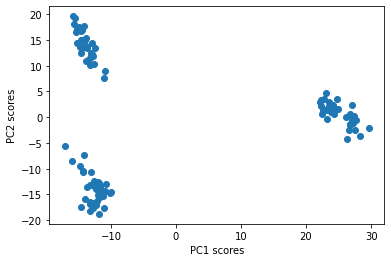

In [4]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#               Fit PCA and use PC scores as model inputs
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# scale data & fit PCA model via pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components = 3))])
score_train = pipe.fit_transform(unfolded_dataMatrix)

# visualize in 2D
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1])
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                       Fit Isolation Forest model
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from sklearn.ensemble import IsolationForest

IF_model = IsolationForest(contamination=0.05)
IF_model.fit(score_train)

IFscore_train = -IF_model.score_samples(score_train) # score_samples returns the anomaly score of the input samples. The lower, the more abnormal.
IF_CL = np.percentile(IFscore_train, 95)

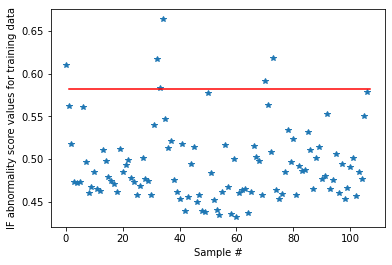

In [6]:
# monitoring chart for training data
plt.figure()
plt.plot(IFscore_train, '*')
plt.plot([1,len(IFscore_train)],[IF_CL, IF_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('IF abnormality score values for training data')
plt.show()

In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                        test data
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [8]:
# fetch test data and unfold
test_dataAll = Etch_data[0,0].test

unfolded_TestdataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(test_dataAll.size):
    test_expt = test_dataAll[expt,0][5:90,2:]
    
    if test_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(test_expt, order='F')[np.newaxis,:]
    unfolded_TestdataMatrix = np.vstack((unfolded_TestdataMatrix, unfolded_row))

unfolded_TestdataMatrix = unfolded_TestdataMatrix[1:,:]

# scale and PCA on faulty test data
score_test = pipe.transform(unfolded_TestdataMatrix)


Number of flagged faults (using control chart):  8
Number of flagged faults (using predict function):  8


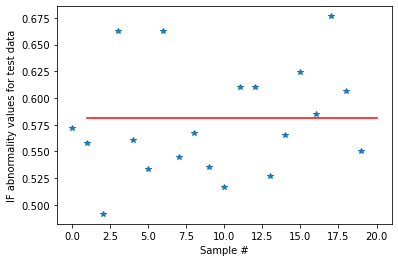

In [9]:
# IF_test
IFscore_test = -IF_model.score_samples(score_test)
print('Number of flagged faults (using control chart): ', np.sum(IFscore_test > IF_CL))

# use predict() function of IF class
print('Number of flagged faults (using predict function): ', np.sum(IF_model.predict(score_test) == -1))

# monitoring chart for test data
plt.figure()
plt.plot(IFscore_test, '*')
plt.plot([1,len(IFscore_test)],[IF_CL, IF_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('IF abnormality values for test data')
plt.show()